# The search for allopatric speciation in the gut microbial communities of Tanganyikan cichlids

## An adventure in fish poo.

*Russell Neches*

In [9]:
%pylab inline
#%config InlineBackend.figure_format='retina'

Populating the interactive namespace from numpy and matplotlib


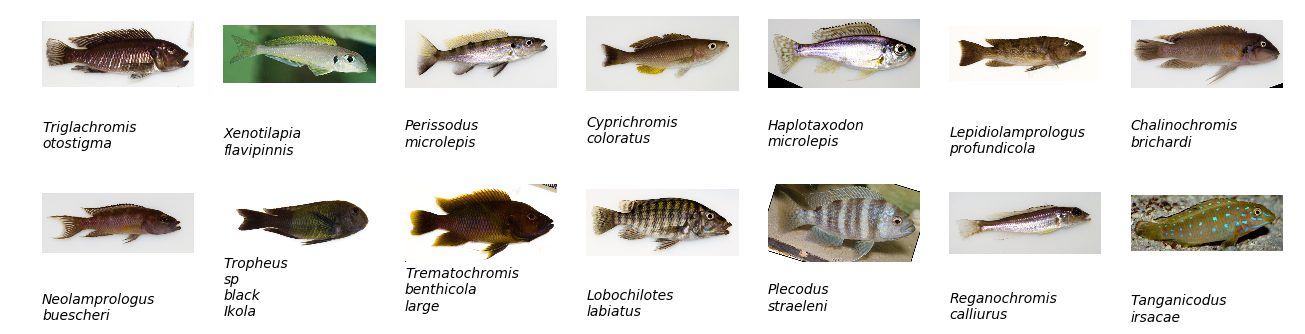

In [2]:
from IPython.display import display, Image
import os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

figure(figsize=(16, 4))

for root, _, files in os.walk('host_phenotypes') :
    for n,file in enumerate(files) :
        i =  mpimg.imread('host_phenotypes/' + file )
        subplot(2,7,n+1)
        plt.imshow(i)
        text( 0, 500, file.replace('_','\n').replace('.png',''), style='italic' )
        plt.axis('off')

In [7]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
#ts.mode = 'c'
ts.show_leaf_name = True
ts.branch_vertical_margin = 1
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0
nstyle["vt_line_width"] = 1
nstyle["hz_line_width"] = 1
nstyle["vt_line_type"] = 0 # 0 solid, 1 dashed, 2 dotted
nstyle["hz_line_type"] = 0

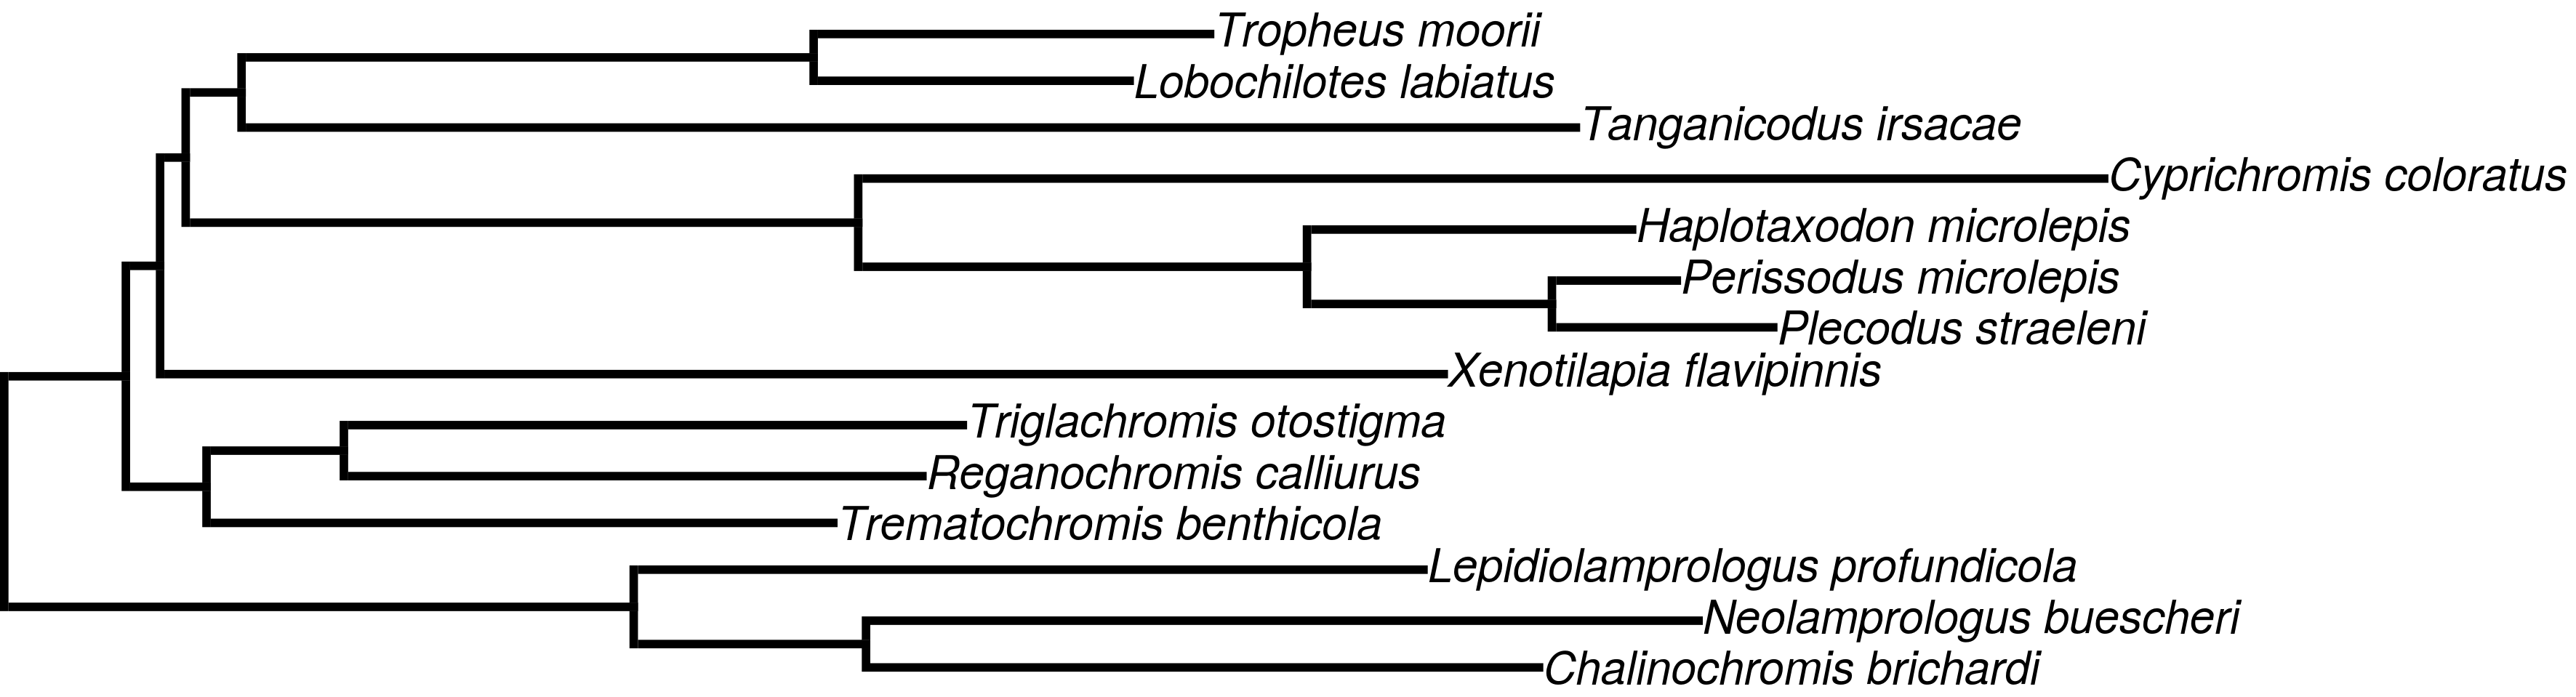

In [8]:
tree = Tree('host_tree/mcgeetree/mcgee_trimmed.tree')

for node in tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 2
        tf.ftype = 'TeX Gyre Heros'
        tf.hz_align = 0
        tf.fstyle = 'italic'
        tf.tight_text = True
        node.add_face( tf, 0 )

tree.render("%%inline", w=1000, units="mm", tree_style=ts)

In [64]:
tree.render("mcgee_tree.pdf", w=1000, units="mm", tree_style=ts)
del(tree)

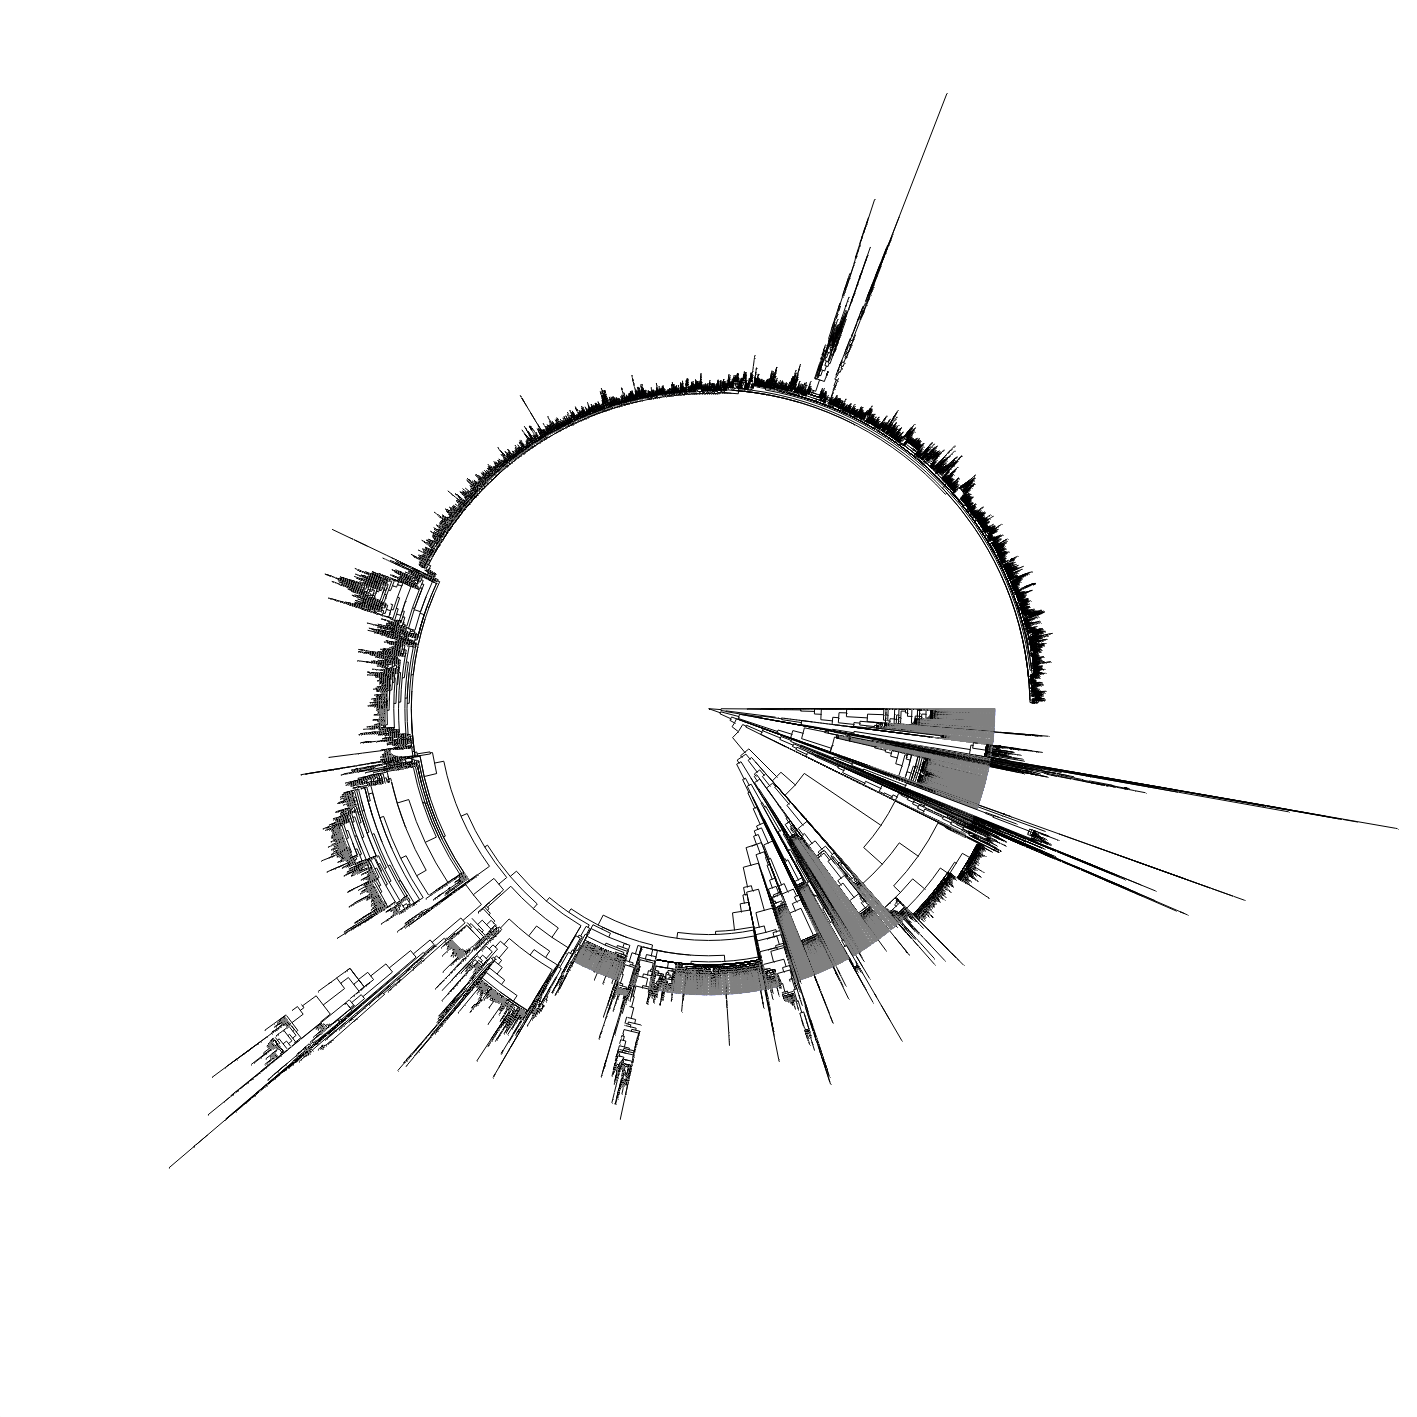

In [58]:
ts = TreeStyle()
ts.mode = 'c'
ts.show_leaf_name = False
ts.branch_vertical_margin = 30
ts.scale = 1000000

t = Tree('dissertation_run_unique_2_clustalo_fasttree.tree')
t.set_outgroup( t.get_midpoint_outgroup() ) # balance the unrooted tree
        
t.render("%%inline", w=400, units="mm", tree_style=ts)

In [65]:
t.render("fishpoo_tree.png", w=2000, units="mm", tree_style=ts)
del(t)

In [9]:
import pandas as pd

df = pd.read_csv( 'dissertation_run_host_abundance_table.tsv', sep='\t', index_col=0 )

# We're going to use this as a trait tabel, so we need to drop 
# non-host control samples 
df = df.drop( ['Water control', 'Charcoal control', 'Food', 'Kit control'] )
df = df.loc[:, (df != 0).any(axis=0)]
df.index = [ i.replace(' ','_') for i in df.index ]
df.to_csv( 'dissertation_run_host_abundance_table_filtered.tsv', sep='\t' )

In [69]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


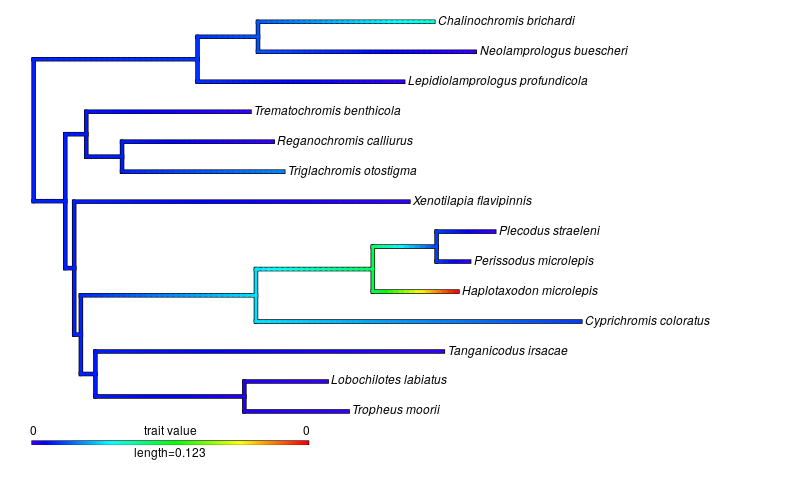

In [70]:
%%R -w 800 -h 480 -u px

# stochastic character mapping

library("phytools")
library("ape")

host_tree <- read.tree("host_tree/mcgeetree/mcgee_trimmed.tree")

phase1_otus <- read.table( file="dissertation_run_host_abundance_table_filtered.tsv", 
                           sep='\t', header=TRUE, row.names=1 )

# use make.simmap() for categorical data : http://www.inside-r.org/packages/cran/phytools/docs/make.simmap
# use contMap() for continious data : http://www.inside-r.org/node/166056

# we need this function to change the color mapping...
# code is from here : http://blog.phytools.org/2014/12/inverting-color-map-on-object-of-class.html
setMap<-function(x,...){
    if(hasArg(invert)) invert<-list(...)$invert
    else invert<-FALSE
    n<-length(x$cols)
    if(invert) x$cols<-setNames(rev(x$cols),names(x$cols))
    else x$cols[1:n]<-colorRampPalette(...)(n)
    x
}

obj <- contMap( host_tree, as.matrix(phase1_otus)[,"CHALBRI.2_10000"], plot=FALSE )
plot(setMap(obj,invert=TRUE))

In [41]:
%%R -w 800 -h 480 -u px
library('geiger')
library('phytools')

#phase1_otus <- read.table( file="fishpoo_phase1_otus_vs_host.csv", sep=',')
td <- treedata( host_tree, phase1_otus )

#phase1_pca <- phyl.pca( rabosky_trimmed, phase1_otus, method="BM", mode="cov")
phase1_pca <- phyl.pca( host_tree, phase1_otus, method="BM", mode="cov" )


plot(phase1_pca$S[,1:2])
text(phase1_pca$S[,1:2]-0.25,rownames(phase1_pca$S), cex.lab=0.3)

#phylomorphospace( host_tree, phase1_pca$S[,1:2] )


Error: cannot allocate vector of size 61.5 Gb


In [71]:
# Let's try to talk to R from python. Then I don't have to figure out 
# how to do parsing, logic and flow control in R anymore

from rpy2.robjects.packages import importr
import rpy2.robjects as ro

# R namespaces are kind of a joke
ape_translations = {'delta.plot'            : 'delta_plot',
                    'delta_plot'            : 'delta__plot',
                    'dist.dna'              : 'dist_dna',
                    'dist_dna'              : 'dist__dna',
                    'dist.nodes'            : 'dist_nodes',
                    'dist_nodes'            : 'dist__nodes',
                    'node.depth'            : 'node_depth',
                    'node_depth'            : 'node__depth',
                    'node.depth.edgelength' : 'node_depth_edgelength',
                    'node_depth_edgelength' : 'node__depth__edgelength',
                    'node.height'           : 'node_height',
                    'node_height'           : 'node__height', 
                    'node.height.clado'     : 'node_height_clado',
                    'node_height_clado'     : 'node__height__clado',
                    'prop.part'             : 'prop_part',
                    'prop_part'             : 'prop__part', }
ape = importr('ape', robject_translations = ape_translations )

phytools = importr('phytools')

adephylo = importr('adephylo')
phylobase = importr('phylobase')

# read in the big fish tree
host_tree = ape.read_tree( "host_tree/mcgeetree/mcgee_trimmed.tree" )

def tree_trait( otu_names, debug=False ) :
    # The bacteria/archaea tree may contain leaves that are not in
    # our OTU table. Those weren't observed, so we just drop them;
    # it works out the same as zero counts for all hosts.
    #otu_names = set(merged_counts.columns).intersection( set(map( lambda l : l.taxon.label, node.leaf_nodes() )) )
    trait_table = df[ otu_names ].sum(axis=1).to_dict()
    #for key in trait_table.keys() :
    #    trait_table[ key.replace( ' ', '_' ) ] = trait_table[key]
    #    del trait_table[key]
    if debug : print trait_table
    r_trate_table = ro.vectors.FloatVector(trait_table.values())
    r_trate_table.names = trait_table.keys()
    return r_trate_table

In [10]:
import dendropy

# walk through the microbe tree, return list of OTUs for each node in the tree 
microbe_tree = dendropy.Tree.get( path='dissertation_run_unique_2_clustalo_fasttree.tree', 
                                  schema='newick', preserve_underscores=True)

# drop leafs that don't have any observations (we previously droped non-host control samples,
# so not all OTUs are observed in the hosts)
drop_leafs = set(i.taxon.label for i in microbe_tree.leaf_nodes()) - set(df.columns)
microbe_tree.prune_taxa_with_labels(drop_leafs)
microbe_tree.write( path='dissertation_run_unique_2_pruned.tree', schema='newick')

print 'dropped', len(drop_leafs), 'taxa, final tree :', len(microbe_tree.leaf_nodes()), 'taxa'

dropped 12588 taxa, final tree : 90858 taxa


In [73]:
from pyprind import ProgBar

progbar = ProgBar( len(microbe_tree.nodes()), monitor=True, title='Listening for phylogenetic signal...' )

f = open( 'dissertation_run_unique_2_phylosig.csv', 'w' )
f.write( ','.join(['n', 'otu', 'leafs', 'K', 'l_lambda', 'l_logL', 'I', 'Cmean']) + '\n' )
#for n,node in enumerate( microbe_tree.postorder_node_iter() ) :
for n,node in enumerate( microbe_tree.preorder_node_iter() ) : 
    leafs = map( lambda l : l.taxon.label, node.leaf_nodes() )
    K = phytools.phylosig( host_tree, tree_trait( leafs ), method='K' )[0]
    l_lambda, l_logL = map( lambda x : x[0], phytools.phylosig( host_tree, tree_trait( leafs ), method='lambda' ) )
    I = adephylo.abouheif_moran( phylobase.phylo4d( host_tree, tree_trait( leafs ) ), method="Abouheif" )[0][0]
    Cmean = adephylo.abouheif_moran( phylobase.phylo4d( host_tree, tree_trait( leafs ) ), method="oriAbouheif" )[0][0]
    node.annotations.add_new( 'Bloomberg K', K )
    node.annotations.add_new( 'Pagel lambda', l_lambda )
    node.annotations.add_new( 'Pagel logL', l_logL )
    node.annotations.add_new( 'Moran I', I )
    node.annotations.add_new( 'Abouheif Cmean', Cmean )
    if node.is_internal() :
        otu = None
    else :
        otu = node.taxon.label
    node.label = n
    f.write( ','.join(map(str,[n, otu, len(leafs), K, l_lambda, l_logL, I, Cmean])) + '\n' )
    #if n%1000 == 0 : print n, node.is_internal(), len(leafs), K, l_lambda, l_logL, I, Cmean
    progbar.update()
f.close()

Listening for phylogenetic signal...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 01:57:48


In [8]:
microbe_tree.write( path='dissertation_run_unique_2_phylosig.nex', schema='nexus')

In [74]:
import pandas as pd

ps = pd.read_csv( 'dissertation_run_unique_2_phylosig.csv', index_col=0 )
ps.head()

,otu,leafs,K,l_lambda,l_logL,I,Cmean
n,,,,,,,
0,None,90858,0.551565,0.015445,379.888668,0.084671,0.142647
1,None,307,0.667240,0.088016,81.337118,0.004947,0.058462
2,None,301,0.666342,0.088602,81.378300,0.004763,0.058046
3,None,297,0.668383,0.092965,81.393562,0.006084,0.059395
4,None,67,0.599815,0.000066,91.401824,-0.067917,-0.011507


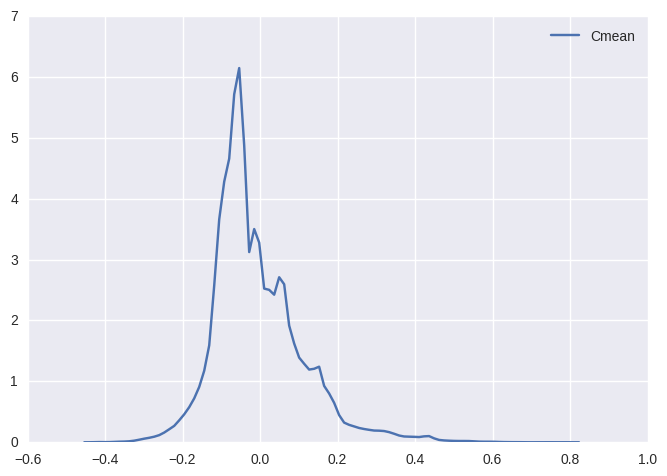

In [10]:
import seaborn

seaborn.kdeplot( ps['Cmean'] )

Plotting phylogenetic signal...
0%                          100%
[###############               ] | ETA: 00:32:16

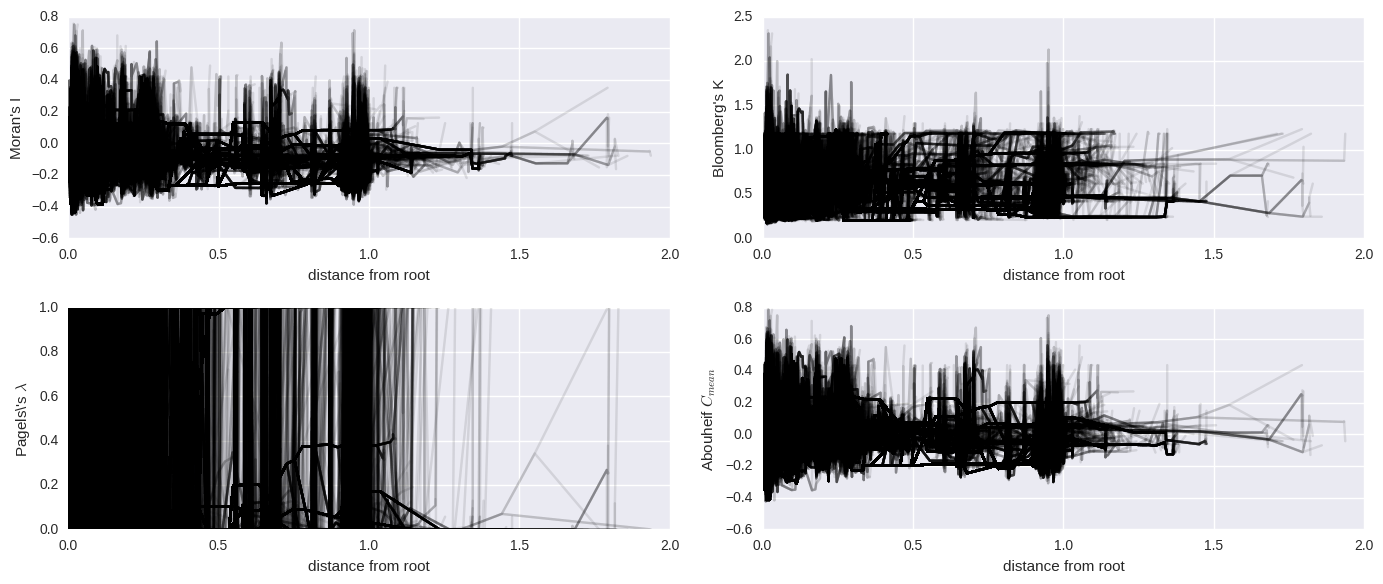

In [23]:
figure(figsize=(14, 6))

progbar = ProgBar( len(microbe_tree.nodes()), monitor=True, title='Plotting phylogenetic signal...' )

for n,leaf in enumerate( microbe_tree.leaf_node_iter() ) :
    #if n == 100 : break
    d = leaf.distance_from_root()
    ds, dt, ks, ls, ms, cs = [],[],[],[],[],[]
    i = leaf
    while i : 
        ds.append( i.distance_from_root() )
        dt.append( i.distance_from_tip() )
        ks.append( i.annotations['Bloomberg K'].value )
        ls.append( i.annotations['Pagel lambda'].value )
        ms.append( i.annotations['Moran I'].value )
        cs.append( i.annotations['Abouheif Cmean'].value )
        i = i.parent_node
    #print leaf., leaf.parent_node, ds
    subplot(221)
    plot(ds,ms,color='black',alpha=0.1)
    xlabel('distance from root')
    ylabel('Moran\'s I')
    
    subplot(222)
    plot(ds,ks,color='black',alpha=0.1)
    xlabel('distance from root')
    ylabel('Bloomberg\'s K')
    
    subplot(223)
    plot(ds,ls,color='black',alpha=0.1)
    xlabel('distance from root')
    ylabel( r'Pagels\'s $\lambda$')
        
    subplot(224)
    plot(ds,cs,color='black',alpha=0.1)
    xlabel('distance from root')
    ylabel( r'Abouheif $C_{mean}$')
    progbar.update()
tight_layout()

In [78]:
#ps[ ps['internal'] == False ].sort_values(by='K',ascending=False)
ps[ ps['otu'] != 'None'].head()

,otu,leafs,K,l_lambda,l_logL,I,Cmean
n,,,,,,,
10,HAPLMIC1_10273,1,0.417820,0.000066,196.486154,-0.078101,-0.060096
12,CYPRCOL6_171436,1,0.824697,0.000066,165.960092,-0.139779,-0.003703
14,CYPRCOL2_37951,1,0.825639,0.000066,167.686754,-0.092346,0.157641
15,TANGIRA1_2066,1,0.755231,0.999934,168.192734,-0.055822,0.055618
17,CYPRCOL2.2_58731,1,0.801841,0.000066,167.827466,-0.091202,0.165087


In [123]:
trait_table = ps[ ps['otu'] != 'None'].join( df.T, on='otu' ).set_index('otu')
trait_table['total'] = df.sum()

trait_table[ trait_table['total'] > .001 ].sort_values('l_lambda', ascending=False)

,leafs,K,l_lambda,l_logL,I,Cmean,Chalinochromis_brichardi,Cyprichromis_coloratus,Haplotaxodon_microlepis,Lepidiolamprologus_profundicola,...,Neolamprologus_buescheri,Perissodus_microlepis,Plecodus_straeleni,Reganochromis_calliurus,Tanganicodus_irsacae,Trematochromis_benthicola,Triglachromis_otostigma,Tropheus_moorii,Xenotilapia_flavipinnis,total
otu,,,,,,,,,,,,,,,,,,,,,
CHALBRI1_5573,1,0.954295,0.999953,109.275035,0.179298,0.220022,0.000202,3.012014e-04,0.000112,0.000261,...,0.000185,0.000046,0.000043,0.000261,0.000264,0.000300,0.000201,0.000009,0.000364,0.002757
CHARCNT_20,1,0.652637,0.999934,63.884994,-0.071890,0.059207,0.000000,9.278715e-06,0.000010,0.000012,...,0.000021,0.000000,0.000000,0.000000,0.000005,0.008598,0.000006,0.000000,0.000117,0.008778
CHALBRI1_1284,1,1.053816,0.999934,89.965434,0.084657,0.172053,0.000458,7.758434e-04,0.000274,0.000915,...,0.000646,0.000137,0.000128,0.000661,0.000843,0.000761,0.000595,0.000100,0.001923,0.008909
CHARCNT_2424,1,0.663554,0.999934,65.944309,-0.050939,0.078405,0.000000,0.000000e+00,0.000298,0.000000,...,0.000000,0.000068,0.000106,0.000546,0.000005,0.007522,0.000000,0.000000,0.000000,0.008545
HAPMIC3.2_27788,1,0.651629,0.999934,90.684411,-0.074101,0.057349,0.000000,0.000000e+00,0.000008,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000005,0.001267,0.000000,0.000000,0.000007,0.001287
PERIMIC1_43671,1,0.650361,0.999934,92.503356,-0.075444,0.056191,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000011,0.000000,0.000000,0.000002,0.001112,0.000000,0.000000,0.000000,0.001126
CHALBRI.2_59542,1,0.606248,0.999934,72.802739,-0.062756,0.005082,0.000003,3.568737e-06,0.000000,0.000113,...,0.000000,0.000000,0.000000,0.004549,0.000000,0.000145,0.000022,0.000000,0.000000,0.004836
CHALBRI.2_12071,1,0.608060,0.999934,87.170703,-0.058310,0.009046,0.000007,7.137473e-07,0.000000,0.000059,...,0.000007,0.000000,0.000021,0.001637,0.000002,0.000070,0.000014,0.000000,0.000000,0.001819
CHALBRI.2_5937,1,0.606248,0.999934,25.383015,-0.063454,0.004351,0.000109,1.698719e-04,0.000016,0.005589,...,0.000305,0.000034,0.000000,0.134681,0.000041,0.004216,0.000833,0.000036,0.000000,0.146054


In [15]:
import dendropy

microbe_tree = dendropy.Tree.get( path='dissertation_run_unique_2_phylosig.nex', 
                                  schema='nexus', preserve_underscores=True)

In [63]:
list(microbe_tree.preorder_node_iter())[181688].taxon.label

'LEPIPRO1_98387'

png 
  2 


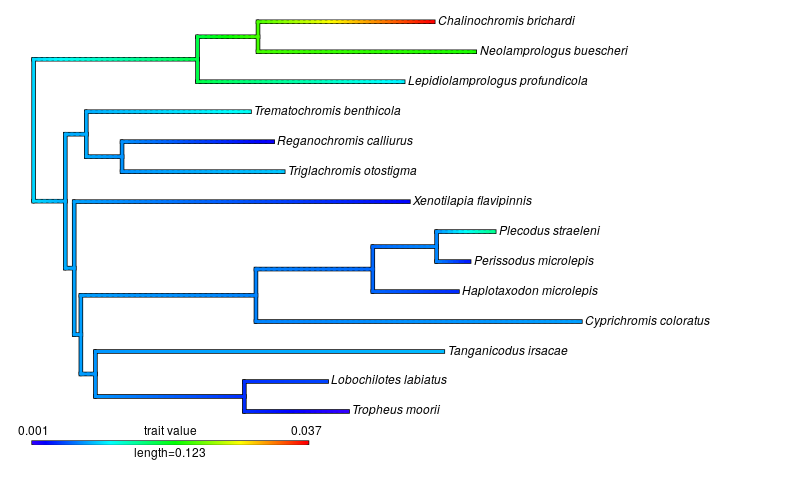

In [122]:
%%R -w 800 -h 480 -u px

# trait values in parts per million
obj <- contMap( host_tree, as.matrix(phase1_otus)[,"CHALBRI1_1198"]*100, plot=FALSE, sig=2 )
plot(setMap(obj,invert=TRUE))

pdf('phylosig_heattree_highsig.pdf', width = 10, height = 5 )
plot(setMap(obj,invert=TRUE))
dev.off()

png 
  2 


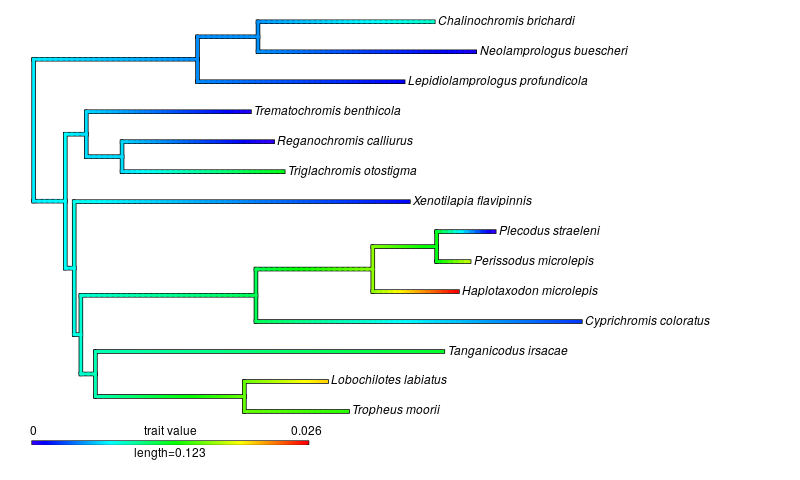

In [120]:
%%R -w 800 -h 480 -u px

# trait values in parts per million
obj <- contMap( host_tree, as.matrix(phase1_otus)[,"CHALBRI1_4931"]*100, plot=FALSE, sig=2 )
plot(setMap(obj,invert=TRUE))

pdf('phylosig_heattree_lowsig.pdf', width = 10, height = 5 )
plot(setMap(obj,invert=TRUE))
dev.off()

In [4]:
from SuchTree import SuchTree, SuchLinkedTrees
import pandas as pd

# checkpoint entry point

host_tree = SuchTree( 'host_tree/mcgeetree/mcgee_trimmed.tree' )
guest_tree = SuchTree( 'dissertation_run_unique_2_pruned.tree' )
links = pd.read_csv( 'dissertation_run_host_abundance_table_filtered.tsv', sep='\t', index_col=0 )

SLT = SuchLinkedTrees( host_tree, guest_tree, links )

In [2]:
from pyprind import ProgBar
from scipy.stats import spearmanr, kendalltau, pearsonr

progbar = ProgBar( len(SLT.TreeB.get_internal_nodes()), monitor=True, title='Calculating Hommola correlations...' )

data = []
for n,nodeid in enumerate(SLT.TreeB.get_internal_nodes()) :
    #if n > 1000 : break
    SLT.subset_b( nodeid )
    progbar.update()
    if SLT.subset_n_links < 5 :
        continue
    if SLT.subset_n_links < 500 :
        d = SLT.linked_distances()
    else :
        d = SLT.sample_linked_distances()
    r, p = pearsonr( d['TreeA'], d['TreeB'] )
    data.append( ( nodeid, SLT.subset_b_size, SLT.subset_n_links, r, p ) )

Calculating Hommola correlations...
0%                          100%
[##############                ] | ETA: 06:20:27/home/russell/opt/local/lib/python2.7/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
[##############################] | ETA: 00:00:00
Total time elapsed: 07:00:13


In [3]:
# checkpoint exit point
hommola = pd.DataFrame( data, columns=['nodeid', 'nleafs', 'nlinks', 'r', 'p' ] )
hommola.to_csv( 'dissertation_run_hommola_correlations.csv', sep=',' )

In [335]:
# checkpoint entry point
hommola = pd.read_csv( 'dissertation_run_hommola_correlations.csv', sep=',', index_col=1 )[['nleafs','nlinks','r','p']]
hommola.head()

,nleafs,nlinks,r,p
nodeid,,,,
135279,90858,235883,0.000323,5.505505e-01
197,67640,169823,0.009309,1.853826e-36
135893,23218,66060,-0.004880,1.504688e-05
115,99,240,-0.043674,1.367758e-13
134845,67541,169583,0.008778,7.605455e-46


In [195]:
from scipy.stats import spearmanr, kendalltau, pearsonr

SLT_gopher_louse = SuchLinkedTrees( SuchTree('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/gopher-louse/gopher.tree'),
                                    SuchTree('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/gopher-louse/lice.tree'),
                                    pd.read_csv('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/gopher-louse/links.csv', index_col=0) )
d = SLT_gopher_louse.linked_distances()
gl_r, gl_p = pearsonr( d['TreeA'], d['TreeB'] )
gl_nleafs = SLT_gopher_louse.TreeB.n_leafs
print 'size of guest tree       :', gl_nleafs
print 'Hommola correlation      :', gl_r
print 'Correlation significance :', gl_p

size of guest tree       : 17
Hommola correlation      : 0.490184989686
Correlation significance : 1.38477623452e-09


In [89]:
from scipy.stats import spearmanr, kendalltau, pearsonr

SLT_sedge_smut = SuchLinkedTrees( SuchTree('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/sedge-smut/host.tree'),
                                  SuchTree('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/sedge-smut/guest.tree'),
                                  pd.read_csv('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/sedge-smut/links.csv', index_col=0) )
d = SLT_sedge_smut.linked_distances()
sm_r, sm_p = pearsonr( d['TreeA'], d['TreeB'] )
sm_nleafs = SLT_sedge_smut.TreeB.n_leafs
print 'size of guest tree       :', sm_nleafs
print 'Hommola correlation      :', sm_r
print 'Correlation significance :', sm_p

size of guest tree       : 27
Hommola correlation      : 0.151791281195
Correlation significance : 1.2693168737e-05


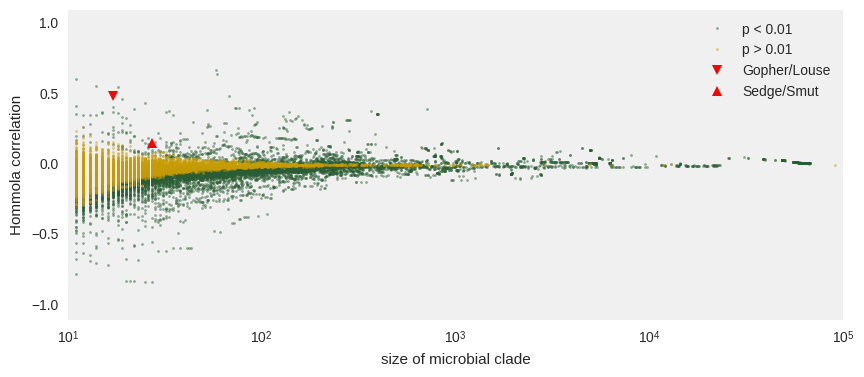

In [207]:
import seaborn

figure(figsize=(10, 4))

with seaborn.axes_style("white"):
    subplot( axisbg='#F0F0F0' )
    ax = plot( hommola[ (hommola.nleafs > 10) & (hommola.p < 0.01) ].nleafs, 
          hommola[ (hommola.nleafs > 10) & (hommola.p < 0.01) ].r, 
          linewidth=0, color=seaborn.xkcd_rgb['pine'],
          marker='o', alpha=0.5, markersize=2,
          label='p < 0.01' )
    ax = plot( hommola[ (hommola.nleafs > 10) & (hommola.p > 0.01) ].nleafs, 
          hommola[ (hommola.nleafs > 10) & (hommola.p > 0.01) ].r, 
          linewidth=0, color=seaborn.xkcd_rgb['ocre'],
          marker='o', alpha=0.5, markersize=2,
          label='p > 0.01' )
    for side in ax[0].axes.spines.keys() :
            ax[0].axes.spines[side].set_visible(False)
    plot( [gl_nleafs], [gl_r], linewidth=0, color='red', marker='v', label='Gopher/Louse' )
    plot( [sm_nleafs], [sm_r], linewidth=0, color='red', marker='^', label='Sedge/Smut' )
    semilogx()
    #axhline(0.1, linewidth=1, linestyle='-', color='black', alpha=0.9)
    ylim(-1.1,1.1)
    xlabel( 'size of microbial clade')
    ylabel( 'Hommola correlation')
    legend()
    
savefig( 'Hommola_correlations.png', dpi=300 )

In [128]:
bigR = hommola[ (hommola.nleafs > 10) & (hommola.p < 0.01) & (hommola.r > 0.1) ]
bigR = bigR.sort_values('r', ascending=False)
bigR.head(10)

,nodeid,nleafs,nlinks,r,p
47124,72311,58,70,0.673018,2.036692e-318
46566,72339,59,73,0.645670,6.499896e-310
39283,82279,11,13,0.611837,2.662861e-09
35848,22929,14,17,0.560684,1.259824e-12
54994,77871,18,23,0.554529,8.442660e-22
46000,72223,68,87,0.488079,3.206487e-223
35533,22919,19,22,0.468834,5.027105e-14
33466,110467,25,50,0.438492,1.014460e-58
46415,46249,11,18,0.417645,7.823672e-08
55617,77839,17,22,0.408787,1.019988e-10


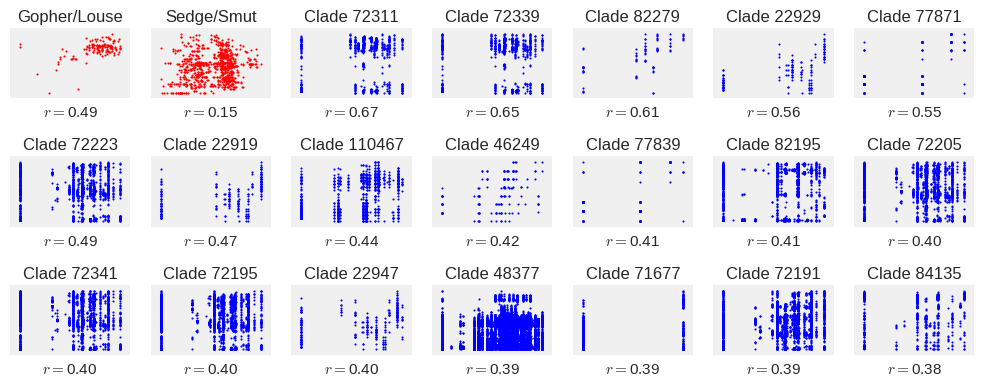

In [124]:
figure(figsize=(10, 4))

with seaborn.axes_style("white") :
    
    subplot(3,7,1, axisbg='#F0F0F0')
    #axis('off')
    d = SLT_gopher_louse.linked_distances()
    r,p = pearsonr(d['TreeA'], d['TreeB'])
    ax = plot( d['TreeA'], d['TreeB'], linewidth=0, color='red', marker='o', markersize=1.5  )
    ax[0].axes.set_xticks( [] )
    ax[0].axes.set_yticks( [] )
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    ax[0].axes.margins( 0.1, 0.1 )
    title( 'Gopher/Louse' )
    xlabel( r'$r=$%1.2f' % r )
    
    subplot(3,7,2, axisbg='#F0F0F0')
    #axis('off')
    d = SLT_sedge_smut.linked_distances()
    r,p = pearsonr(d['TreeA'], d['TreeB'])
    ax = plot( d['TreeA'], d['TreeB'], linewidth=0, color='red', marker='o', markersize=1.5 )
    ax[0].axes.set_xticks( [] )
    ax[0].axes.set_yticks( [] )
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    ax[0].axes.margins( 0.1, 0.1 )
    title( 'Sedge/Smut' )
    xlabel( r'$r=$%1.2f' % r )
        
    for m,(n,row) in enumerate(bigR.iterrows()) :
        if m >= 19 : break
        subplot(3,7,m+3, axisbg='#F0F0F0')
        #axis('off')
        SLT.subset_b(row.nodeid)
        d = SLT.linked_distances()
        r,p = pearsonr(d['TreeA'], d['TreeB'])
        ax = plot( d['TreeA'], d['TreeB'], linewidth=0, color='blue', marker='o', markersize=1.5 )
        ax[0].axes.set_xticks( [] )
        ax[0].axes.set_yticks( [] )
        for side in ax[0].axes.spines.keys() :
            ax[0].axes.spines[side].set_visible(False)
        ax[0].axes.margins( 0.1, 0.1 )
        title( 'Clade ' + str(int(row.nodeid)) )
        xlabel( r'$r=$%1.2f' % r )

tight_layout()
    
savefig( 'High_correlation_clades.png', dpi=300 )

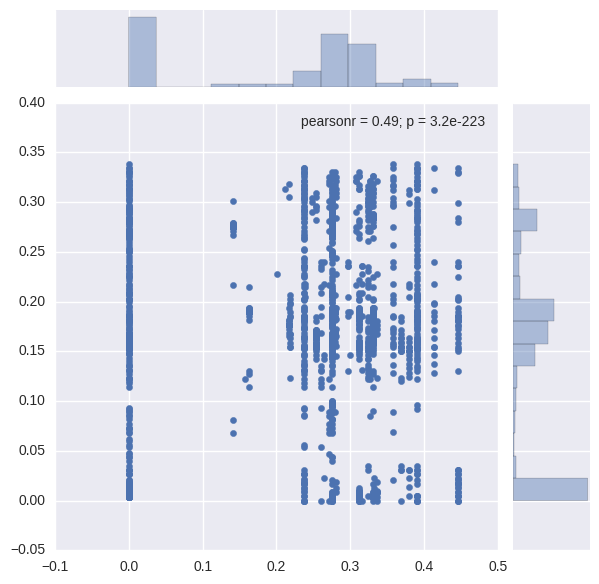

In [20]:
import seaborn

cladeid = 72223

SLT.subset_b( cladeid )
d = SLT.linked_distances()
seaborn.jointplot( d['TreeA'], d['TreeB'] )

In [22]:
import dendropy

microbe_tree = dendropy.Tree.get( path='dissertation_run_unique_2_pruned.tree', 
                                  schema='newick', preserve_underscores=True)

sfeal = dict( zip( SLT.TreeB.leafs.values(), SLT.TreeB.leafs.keys() ) )
clade_leafs = [ sfeal[nodeid] for nodeid in SLT.subset_b_leafs ]

microbe_tree.retain_taxa_with_labels( clade_leafs )

microbe_tree.write( path='dissertation_run_clade_72223.tree', schema='newick' )

In [59]:
clinks = links[ clade_leafs ]
uclinks = clinks.applymap( bool ).unstack()
uclinks = uclinks[ uclinks ]
with open( str(cladeid) + '.links', 'w' ) as f :
    for pair in list(uclinks.index) :
        f.write( '\t'.join([ ''+i+'' for i in pair[::-1] ]) + '\n' )

In [60]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Rotating nodes to optimize matching...
Done.
png 
  2 


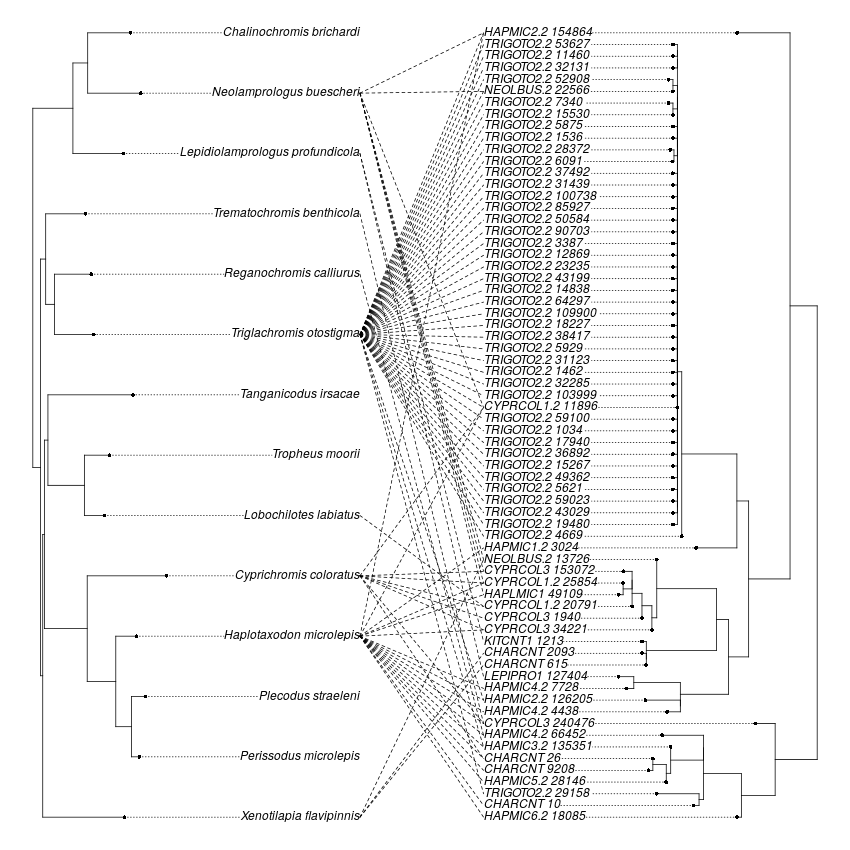

In [85]:
%%R -w 30 -h 30 -u cm

library('phytools')

tr1 <- read.tree( 'host_tree/mcgeetree/mcgee_trimmed.tree' )
tr2 <- read.newick( 'dissertation_run_clade_72223_edit.tree' )
tr2 <- collapse.singles(tr2)
assoc = as.matrix(read.csv( '72223.links', sep='\t', header=FALSE ))
colnames(assoc)<-c('tips.tr1','tips.tr2')

obj <- cophylo( tr1, tr2, assoc=assoc )
plot(obj)

pdf('codiv_clade_72223.pdf', width = 10, height = 12 )
plot(setMap(obj,invert=TRUE))
dev.off()

In [80]:
links = pd.read_csv('https://raw.githubusercontent.com/ryneches/SuchTree/master/data/gopher-louse/links.csv', index_col=0)

uclinks = links.applymap( bool ).unstack()
uclinks = uclinks[ uclinks ]
with open( 'gopher-louse.links', 'w' ) as f :
    for pair in list(uclinks.index) :
        f.write( '\t'.join([ ''+i+'' for i in pair[::-1] ]) + '\n' )

Rotating nodes to optimize matching...
Done.
png 
  2 


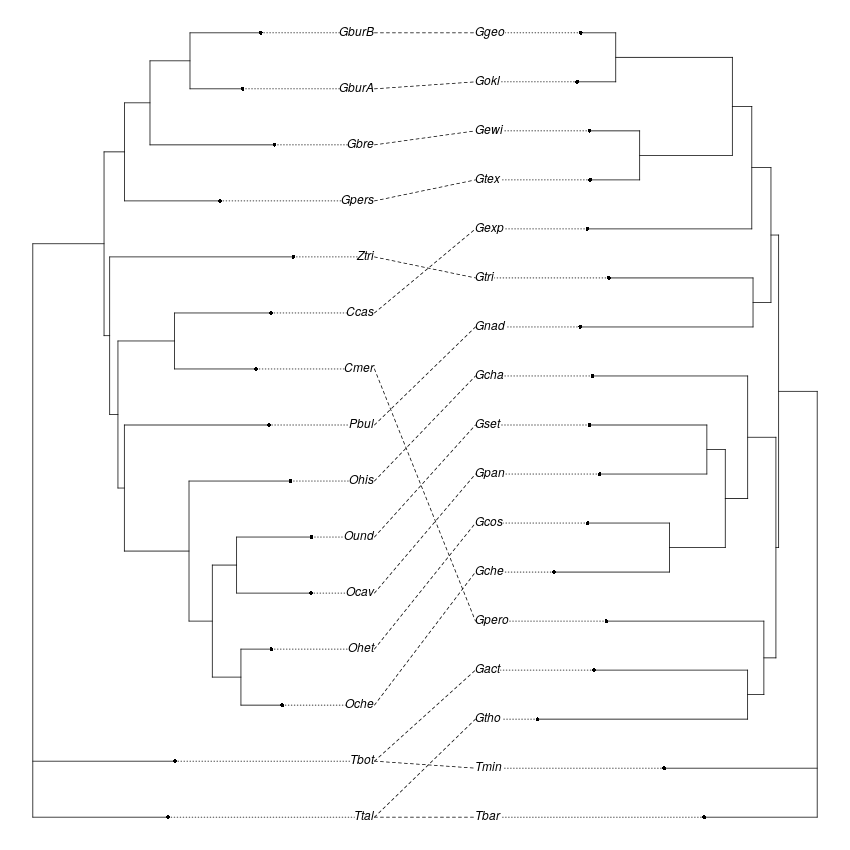

In [86]:
%%R -w 30 -h 30 -u cm

library('phytools')

tr1 <- read.tree( '../SuchTree/data/gopher-louse/gopher.tree' )
tr2 <- read.newick( '../SuchTree/data/gopher-louse/lice.tree' )
tr2 <- collapse.singles(tr2)
assoc = as.matrix(read.csv( 'gopher-louse.links', sep='\t', header=FALSE ))
colnames(assoc)<-c('tips.tr1','tips.tr2')

obj <- cophylo( tr1, tr2, assoc=assoc )
plot(obj)

pdf('codiv_gopher_louse.pdf', width = 10, height = 12 )
plot(setMap(obj,invert=TRUE))
dev.off()

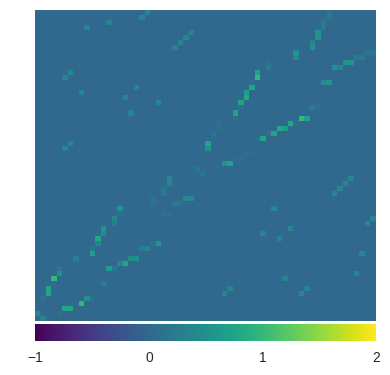

In [145]:
figure(figsize=(4,4))
aj = SLT_gopher_louse.adjacency()
pcolor(aj, cmap='viridis', vmin=-1, vmax=2)
xlim( (0,aj.shape[0]) )
ylim( (0,aj.shape[1]) )
#xticks([])
#yticks([])
axis('off')
colorbar( ticks=[-1,0,1,2], orientation='horizontal', pad=0.01 )
tight_layout()

savefig( 'gopher_louse_adjacency.png', dpi=100 )

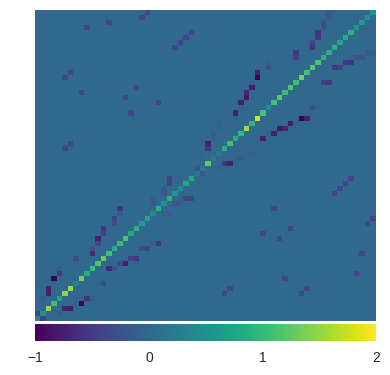

In [146]:
figure(figsize=(4,4))
lp = SLT_gopher_louse.laplacian()
pcolor(lp, cmap='viridis', vmin=-1, vmax=2)
xlim( (0,lp.shape[0]) )
ylim( (0,lp.shape[1]) )
#xticks([])
#yticks([])
axis('off')
colorbar( ticks=[-1,0,1,2], orientation='horizontal', pad=0.01 )
tight_layout()

savefig( 'gopher_louse_laplacian.png', dpi=300 )

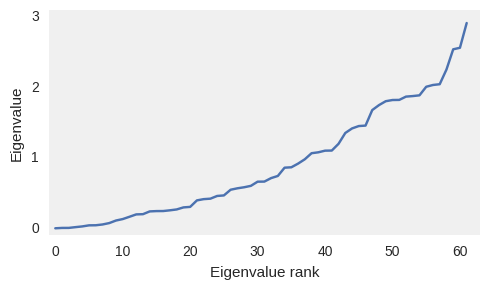

In [314]:
figure(figsize=(5,3))

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')
    ax = plot( lambdas )
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( 'Eigenvalue rank' )
    ylabel( 'Eigenvalue' )
    ax[0].axes.set_yticks([0,1,2,3])
    xlim( [-1,63] )
    ylim( [-0.1,3.1] )

tight_layout()

savefig( 'gopher_louse_eigenvalues.pdf', dpi=100 )

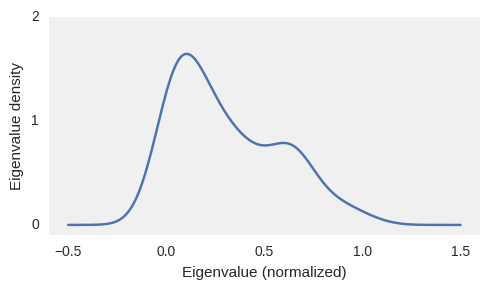

In [272]:
from scipy.stats import skew, entropy, gaussian_kde, kurtosis

figure(figsize=(5,3))

bandwidth = 0.4
lambdas = SLT_gopher_louse.spectrum()

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')
    X = linspace( -0.5,1.5,200 )
    ax = plot( X, gaussian_kde( lambdas/max(lambdas), bw_method=bandwidth ).pdf( X ) )
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( 'Eigenvalue (normalized)' )
    ylabel( 'Eigenvalue density' )
    ax[0].axes.set_yticks([0,1,2])
    xlim( [-0.6,1.6] )
    ylim( [-0.1,2] )

tight_layout()

savefig( 'gopher_louse_spectral_density.pdf', dpi=100 )

In [31]:
import igraph

def permute_links( linklist, deletions, additions, swaps ) :
    ll = array( linklist )
    for i in xrange( 1, deletions ) :
        ll = delete( ll, randint(len(ll)), axis=0 )
    for i in xrange( 1, swaps ) :
        x, y = random.choice( xrange( len(ll) ), size=2, replace=False )
        X, Y = ll[x,1], ll[y,1]
        ll[x,1] = Y
        ll[y,1] = X
    for i in xrange( 1, additions ) :
        a = random.choice( SLT.TreeA.leafs.values() )
        b = random.choice( SLT.TreeB.leafs.values() )
        ll = numpy.concatenate( (ll, array([[b,a]])), axis=0 )
    return ll

def edge_mean( aj ) :
    return mean( aj.flatten()[ aj.flatten() > SLT.TreeA.polytomy_distance ] )

def pdd( a, b ) :
    '''Jensen–Shannon distance'''
    return ( 0.5 * entropy( a, b ) + 0.5 * entropy( b, a ) )**(0.5)

def graph_spectral_density( SLT, deletions=0, additions=0, swaps=0, mode='lambdas' ) :
    
    linklist = permute_links( SLT.linklist, deletions, additions, swaps )
    
    host_aj,  host_node_ids  = SLT.TreeA.adjacency( SLT.TreeA.root ).values()
    guest_aj, guest_node_ids = SLT.TreeB.adjacency( SLT.TreeB.root ).values()
    
    host_node_ids, guest_node_ids = host_node_ids.tolist(), guest_node_ids.tolist()
    
    guest_aj_links = map( lambda x : guest_node_ids.index(x) + host_aj.shape[0] , linklist[:,0] )
    host_aj_links  = map( lambda x : host_node_ids.index(x), linklist[:,1] )
    #zip(guest_aj_links, host_aj_links )
    
    aj = zeros( ( host_aj.shape[0] + guest_aj.shape[0], host_aj.shape[1] + guest_aj.shape[1] ) )
    aj[ 0:host_aj.shape[0], 0:host_aj.shape[1] ] = host_aj / host_aj.max()
    aj[ host_aj.shape[0]:, host_aj.shape[1]: ] = guest_aj / guest_aj.max()
    
    host_mean  = edge_mean( host_aj  / host_aj.max()  )
    guest_mean = edge_mean( guest_aj / guest_aj.max() )
    
    for i,j in zip( guest_aj_links, host_aj_links ) :
        aj[i,j] = ( host_mean + guest_mean ) / 2.0
        aj[j,i] = ( host_mean + guest_mean ) / 2.0
        
    if mode == 'adjacency' :
        return aj
    
    g = igraph.Graph.Weighted_Adjacency( aj.tolist(), mode=igraph.ADJ_UNDIRECTED )
    lp = matrix(g.laplacian( weights='weight', normalized=False ))
    
    host_g = igraph.Graph.Weighted_Adjacency(  host_aj.tolist(),  mode=igraph.ADJ_UNDIRECTED )
    guest_g = igraph.Graph.Weighted_Adjacency( guest_aj.tolist(), mode=igraph.ADJ_UNDIRECTED )
    
    host_lp  = matrix( host_g.laplacian(  weights='weight', normalized=False ))
    guest_lp = matrix( guest_g.laplacian( weights='weight', normalized=False ))
    
    if mode == 'laplacian' :
        return lp
    
    lambdas   = linalg.eigvalsh( lp )
    lambdas_h = linalg.eigvalsh( host_lp )
    lambdas_g = linalg.eigvalsh( guest_lp )
    return { 'graph' : lambdas, 'host' : lambdas_h, 'guest' : lambdas_g }

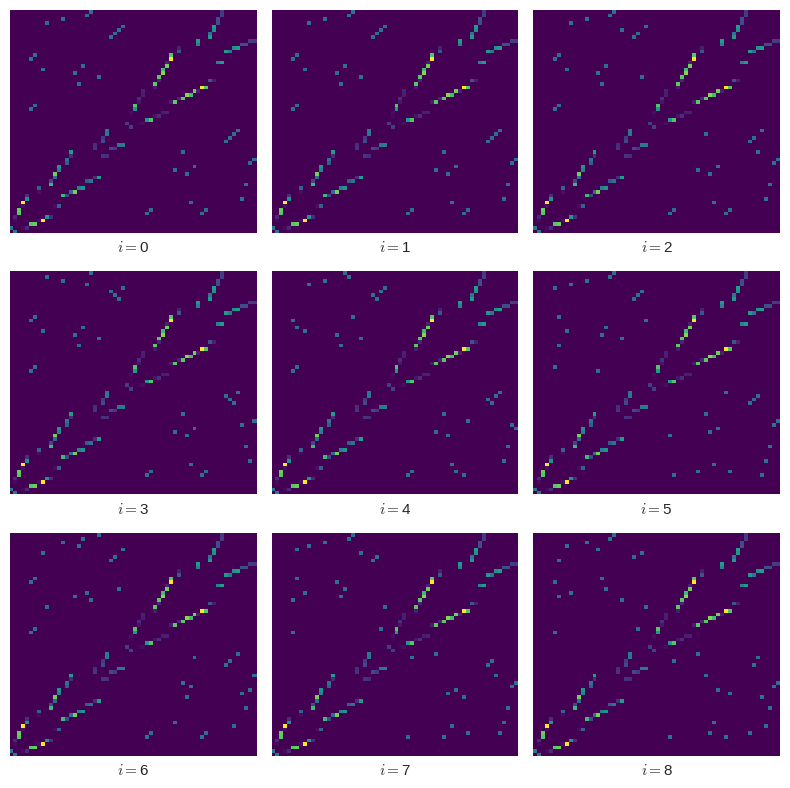

In [227]:
figure(figsize=(8,8))
for i in xrange( 9 ) :
    subplot(3,3,i+1)
    aj = graph_spectral_density( SLT_gopher_louse, additions=0, deletions=0, swaps=i, mode='adjacency' )
    ax = pcolor( aj, cmap='viridis', vmin=0, vmax=1 )
    xlim( (0,aj.shape[1]) )
    ylim( (0,aj.shape[0]) )
    
    ax.axes.set_xticks( [] )
    ax.axes.set_yticks( [] )
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    ax.axes.margins( 0.1, 0.1 )
    xlabel( r'$i=$%d' % i )

tight_layout()

savefig( 'gopher_louse_adjacency_permutations.png', dpi=300 )

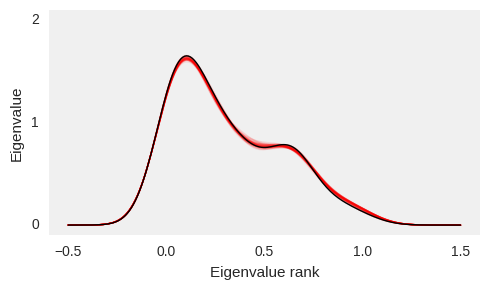

In [325]:
from scipy.stats import skew, entropy, gaussian_kde, kurtosis
import pyprind

figure( figsize=(5,3) )

bandwidth = 0.4

L,spectra = [],[]
for i in linspace( 0, 50, 51 ) :
    lambdas = graph_spectral_density( SLT_gopher_louse, additions=0, deletions=0, swaps=int(i) )['graph']
    L.append(lambdas)

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')
    
    for i,lambdas in enumerate(L[::-1]) :
        spectra.append( gaussian_kde( lambdas / max(lambdas), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) ) )
        #seaborn.kdeplot( lambdas / lambdas.max(), label=int(i), bw=0.1 )
        if i == 50 :
            c = 'black'
            a = 1.0
        else :
            c = 'red'
            a = 0.1
        ax = plot( linspace( -0.5,1.5,200), spectra[-1], color=c, alpha=a, linewidth=1 )
    
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( 'Eigenvalue rank' )
    ylabel( 'Eigenvalue' )
    ax[0].axes.set_yticks( [0,1,2] )
    xlim( [-0.6,1.6] )
    ylim( [-0.1,2.1] )

tight_layout()

savefig( 'gopher_louse_spectral_density_permutations.pdf', dpi=100 )

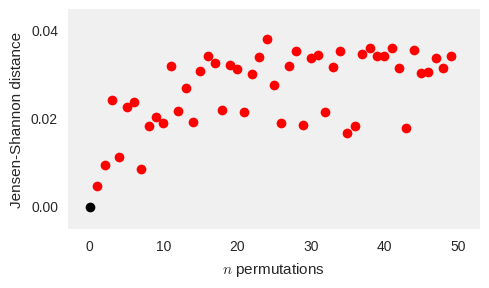

In [327]:
figure( figsize=(5,3) )

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    a = gaussian_kde( L[0] / max(L[0]), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
    for i,l in enumerate(L[1:]) :
        b = gaussian_kde( l / max(l), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
        if i == 0 :
            c = 'black'
        else :
            c = 'red'
        ax = plot( i, e**pdd(a,b)-1, marker='o', color=c )
        
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( r'$n$ permutations' )
    ylabel( 'Jensen-Shannon distance' )
    ax[0].axes.set_yticks( [0,0.02,0.04] )
    xlim( [-3,53] )
    ylim( [-0.005,0.045] )

tight_layout()

savefig( 'gopher_louse_spectral_density_permutation_distances.pdf', dpi=100 )

In [226]:
from SuchTree import SuchTree, SuchLinkedTrees, pearson
from scipy.stats import skew, entropy, gaussian_kde, kurtosis
import pandas as pd
import seaborn
import json
import pyprind

studies = json.load( open( '../SuchTree/data/studies.json' ) )

def load_study( study ) :
    T1  = SuchTree( '../SuchTree/' + study['host'] )
    T2  = SuchTree( '../SuchTree/' + study['guest'] )
    links = pd.DataFrame.from_csv( '../SuchTree/' + study['links'] )
    links = links.loc[ T1.leafs.keys() ]
    links = links[ T2.leafs.keys() ]
    return SuchLinkedTrees( T1, T2, links )

In [231]:
pbar = pyprind.ProgBar( len(studies), title='building graph Laplacian spectra...' )

bandwidth = 0.4

for study in studies :
    SLT = load_study( study )
    eg = SLT.spectrum()
    case = {}
    study['eigenvalues'] = eg
    study['spectrum'] = gaussian_kde( eg / max(eg), bw_method=bandwidth ).pdf( linspace( -0.5,1.5,200) )
    study['skew'] = skew( study['spectrum'] )
    study['kurtosis'] = kurtosis( study['spectrum'] )
    study['eigengap'] = eg[-1]-eg[-2]
    study['nlinks'] = SLT.n_links
    d = SLT.linked_distances()
    r,p = pearsonr( d['TreeA'], d['TreeB'] )
    study['r'] = r
    study['p'] = p
    pbar.update()

building graph Laplacian spectra...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:00:14


In [228]:
Studies = pd.DataFrame(studies)[['name', 
                                 'eigengap',
                                 'kurtosis',
                                 'skew',
                                 'r',
                                 'p',
                                 'nlinks',
                                 'type',
                                 'spectrum']].set_index('name')
Studies.head()

,eigengap,kurtosis,skew,r,p,nlinks,type,spectrum
name,,,,,,,,
"Gopher, Lice",0.356124,-0.703048,0.742754,0.490185,1.384776e-09,17,parasitism,"[7.81868399503e-06, 1.21635779187e-05, 1.87617..."
"Sedge, Smut",0.394546,1.991885,1.814341,0.151791,1.269317e-05,41,parasitism,"[2.8437729563e-11, 7.36387082764e-11, 1.871346..."
beeh,1.807349,1.067350,1.584365,-0.036276,2.365234e-03,119,frugivory,"[1.13792135656e-09, 2.48194233395e-09, 5.33383..."
arr1,7.059804,7.519471,2.908209,0.044583,4.164964e-22,307,pollination,"[8.26393111014e-31, 1.26415814618e-29, 1.83172..."
arr2,3.116884,1.882773,1.826080,0.054153,8.319668e-11,170,pollination,"[5.88480263637e-14, 1.88603935338e-13, 5.90979..."


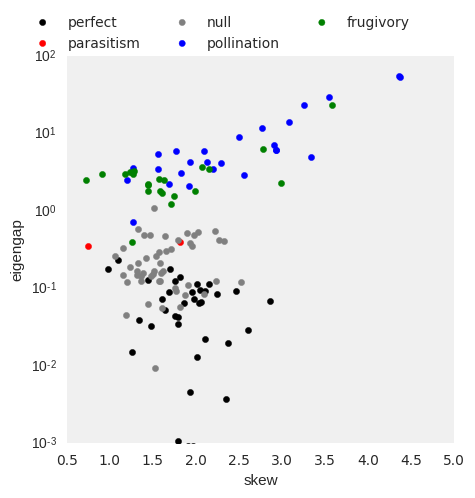

In [229]:
figure(figsize=(5,5))

typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'green',
              'pollination' : 'blue' }

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    for ecology, color in typecolor.iteritems() :
        S = Studies[ Studies['type'] == ecology]
        ax = scatter( S['skew'], S['eigengap'], color=color, label=ecology )
        #for spectrum in S['spectrum'] :
        #    ax = plot( spectrum, color=color, label=ecology, linewidth=1 )

    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'skew' )
    ylabel( 'eigengap' )
    #ax.axes.set_yticks( [0,0.02,0.04] )
    #xlim( [-3,53] )
    #ylim( [-1,3] )
    
semilogy()
ax.axes.legend(bbox_to_anchor=(0.9, 1.06), loc=7, borderaxespad=0., ncol=3)
#tight_layout()

savefig( 'codiv_literature_skew_eigengap.pdf', dpi=100 )

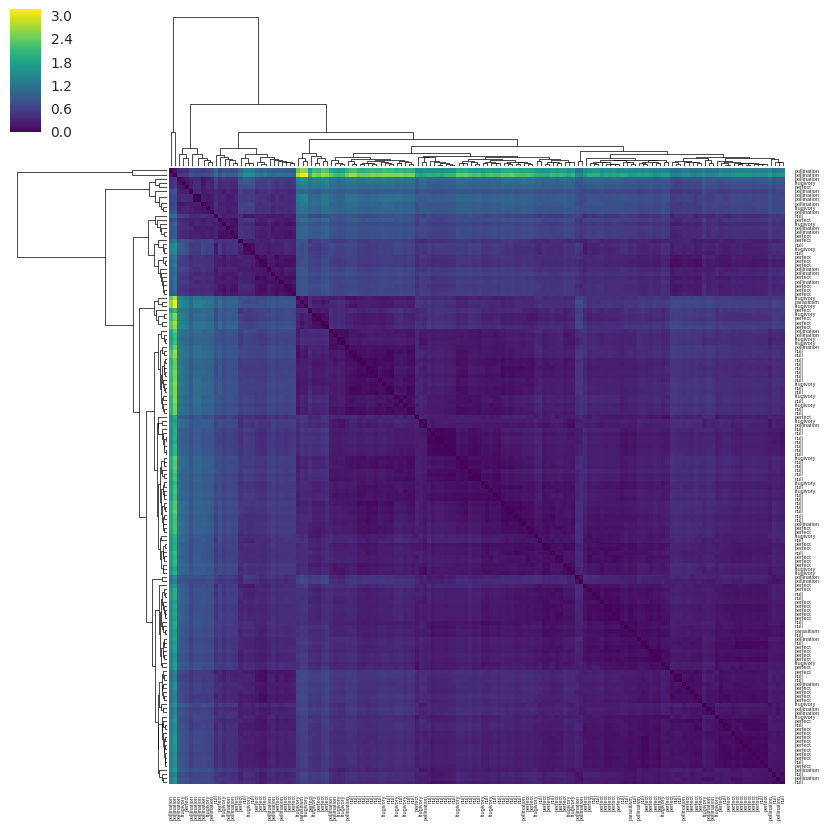

In [293]:
figure(figsize=(3,3))

distances = zeros( ( len(studies), len(studies) ) )

for i,I in enumerate(Studies.spectrum) :
    for j,J in enumerate(Studies.spectrum) :
        if i == j : continue
        #distances[i,j] = log(1+pdd( I, J ))
        distances[i,j] = pdd( I, J )

studytypes = map( lambda x : x['type'], studies )
cm = seaborn.clustermap( distances, 
                         xticklabels=studytypes, 
                         yticklabels=studytypes, 
                         metric='euclidean', 
                         cmap='viridis' )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=4 )
ticks = setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=4 )

savefig( 'codiv_literature_clustermap.pdf', dpi=100 )

In [235]:
from SuchTree import SuchTree, SuchLinkedTrees
import pandas as pd

# checkpoint entry point

host_tree = SuchTree( 'host_tree/mcgeetree/mcgee_trimmed.tree' )
guest_tree = SuchTree( 'dissertation_run_unique_2_pruned.tree' )
links = pd.read_csv( 'dissertation_run_host_abundance_table_filtered.tsv', sep='\t', index_col=0 )

SLT = SuchLinkedTrees( host_tree, guest_tree, links )

In [21]:
from pyprind import ProgBar
from scipy.stats import spearmanr, kendalltau, pearsonr

progbar = ProgBar( len(SLT.TreeB.get_internal_nodes()), monitor=True, title='Calculating eigenvalues...' )

data = []

for n,nodeid in enumerate(SLT.TreeB.get_internal_nodes()) :
    #f n > 1000 : break
    SLT.subset_b( nodeid )
    progbar.update()
    if SLT.subset_n_links < 5 :
        continue
    if SLT.subset_n_links > 500 :
        continue
    data.append( ( nodeid, SLT.spectrum() ) )

Calculating eigenvalues...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:27:38


In [248]:
from scipy.stats import skew, entropy, gaussian_kde, kurtosis
from pyprind import ProgBar

progbar = ProgBar( len(data), monitor=True, title='Computing spectral densities...' )

bandwidth = 0.4

X = linspace( -0.5,1.5,200)
allspectra = []
for n,(nodeid,eg) in enumerate(data) :
    #if n > 100 : break
    s = gaussian_kde( eg / max(eg), bw_method=bandwidth ).pdf( X )
    #plot(X,s)
    allspectra.append( (nodeid,s) )
    progbar.update()

Computing spectral densities...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:01:00


In [250]:
spectral_stats = {}
for nodeid,s in allspectra :
    spectral_stats[nodeid] = {}
    spectral_stats[nodeid]['kurtosis'] = kurtosis(s)
    spectral_stats[nodeid]['skew'] = skew(s)
for nodeid,eg in data :
    spectral_stats[nodeid]['eigengap'] = eg[-1]-eg[-2]
spectral_stats = pd.DataFrame(spectral_stats).T
spectral_stats.head()

,eigengap,kurtosis,skew
3,0.292547,-0.059142,1.054614
5,0.383861,-0.044940,1.053477
7,3.504506,2.964468,2.088225
11,0.424694,0.195170,1.138808
15,2.227516,0.626871,1.383381


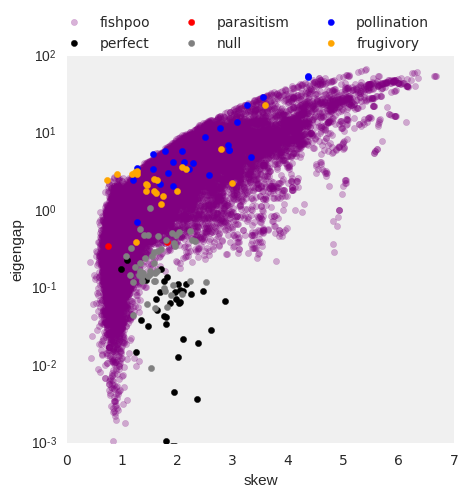

In [262]:
figure(figsize=(5,5))

typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'orange',
              'pollination' : 'blue' }

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    ax = scatter( spectral_stats['skew'], spectral_stats['eigengap'], 
                  color='purple', alpha=0.3, label='fishpoo' )
    
    for ecology, color in typecolor.iteritems() :
        S = Studies[ Studies['type'] == ecology]
        scatter( S['skew'], S['eigengap'], color=color, label=ecology )
        #for spectrum in S['spectrum'] :
        #    ax = plot( spectrum, color=color, label=ecology, linewidth=1 )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'skew' )
    ylabel( 'eigengap' )
    #ax.axes.set_yticks( [0,0.02,0.04] )
    #xlim( [-3,53] )
    ylim( [10**-3,100] )
    
    semilogy()
    ax.axes.legend(bbox_to_anchor=(0.95, 1.06), loc=7, borderaxespad=0., ncol=3)
    
    #tight_layout()

savefig( 'codiv_literature_fishpoo_skew_eigengap.png', dpi=300 )

In [265]:
from pyprind import ProgBar

progbar = ProgBar( len(allspectra)*len(studies), monitor=True, title='Calculating spectral distnaces...' )

all_distances = zeros( ( len(allspectra), len(studies) ) )

for n,(nodeid,s) in enumerate( allspectra ) :
    for m,study in enumerate( studies ) :
        all_distances[ n, m ] = pdd( s, study['spectrum' ] )
        progbar.update()

Calculating spectral distnaces...
0%                          100%
[##############################] | ETA: 00:00:00
Total time elapsed: 00:07:38


In [266]:
# checkpoint exit

AD = pd.DataFrame(all_distances, index=zip(*data)[0], columns=[ study['name'] for study in studies ] )
AD.to_csv( 'dissertation_spectral_distances.csv', sep=',' )

In [3]:
import pandas as pd
# checkpoint entry

AD = pd.read_csv( 'dissertation_spectral_distances.csv.gz', sep=',', index_col=0 )

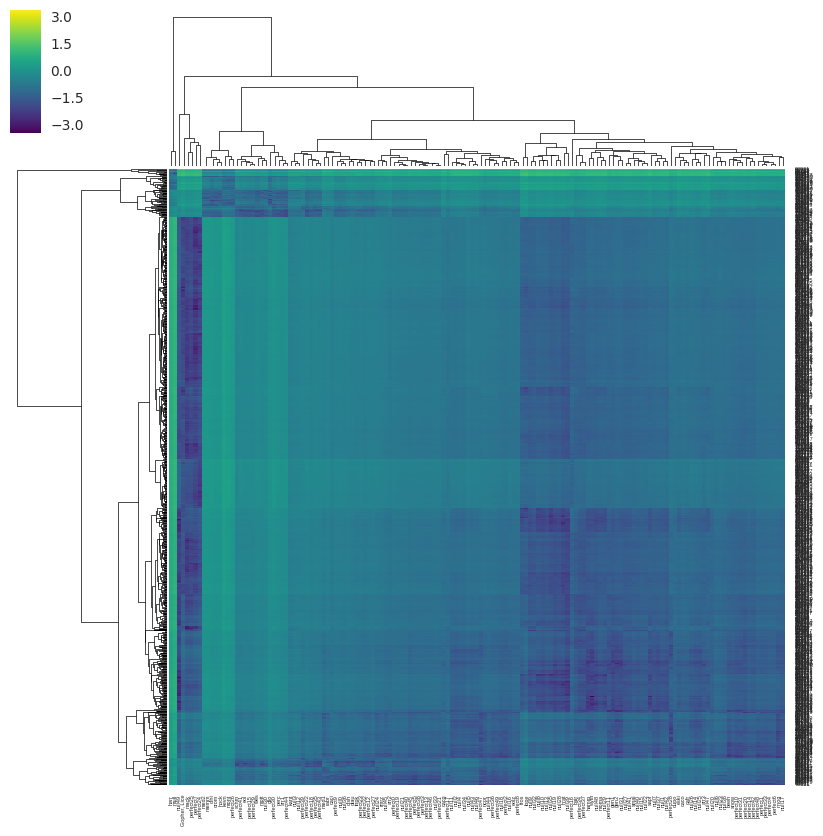

In [121]:
import seaborn

AD_sample = AD.sample(n=1000).applymap(log)

cm = seaborn.clustermap( AD_sample.as_matrix(), 
                         xticklabels=AD_sample.columns, 
                         yticklabels=AD_sample.index, 
                         metric='euclidean', 
                         cmap='viridis' )
ticks = setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0, fontsize=4 )
ticks = setp(cm.ax_heatmap.xaxis.get_majorticklabels(), fontsize=4 )

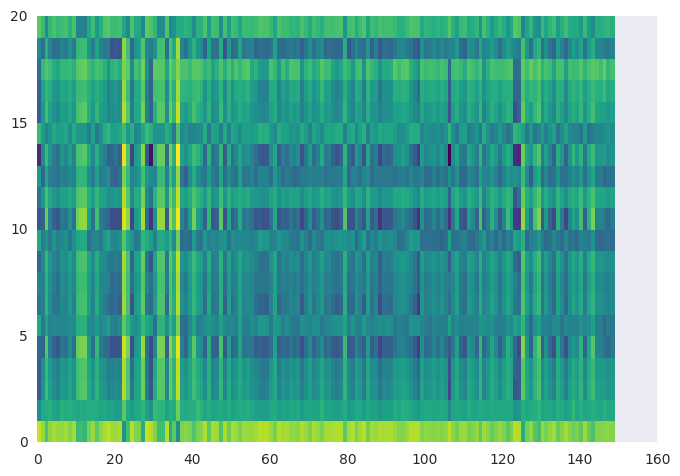

In [78]:
from scipy.cluster.vq import kmeans, kmeans2

#clustered = single(AD.as_matrix())
#pcolor( all_distances )
#plot(AD.as_matrix()[:,0], 'ro')

a = kmeans2( AD_sample, 20 )
pcolor( a[0], cmap='viridis' )

[ 0.94049442  0.04412977  0.00970708  0.00288966  0.00100819]


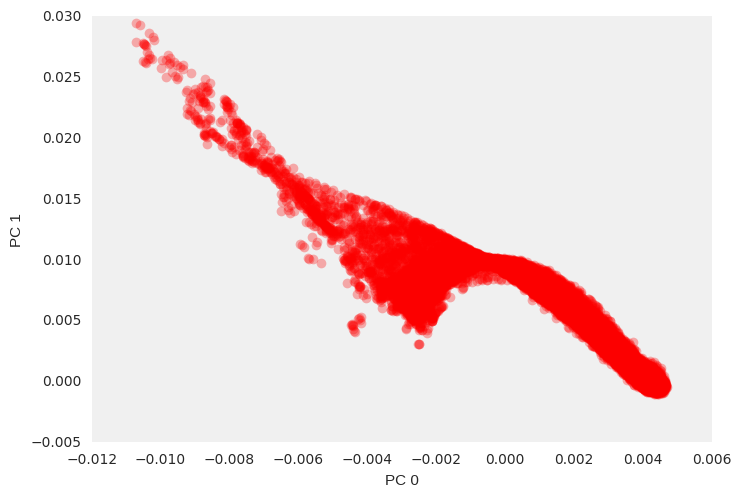

In [269]:
from sklearn.decomposition import PCA

pca = PCA( n_components=5, whiten=False )
p = pca.fit( AD.T )
X = p.transform( AD.T )
print p.explained_variance_ratio_

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    ax = plot( p.components_[0], p.components_[1], 'ro', alpha=0.3 )
    
    for side in ax[0].axes.spines.keys() :
        ax[0].axes.spines[side].set_visible(False)
    xlabel( 'PC 0' )
    ylabel( 'PC 1' )


In [181]:
SLT.TreeB.n_leafs

151

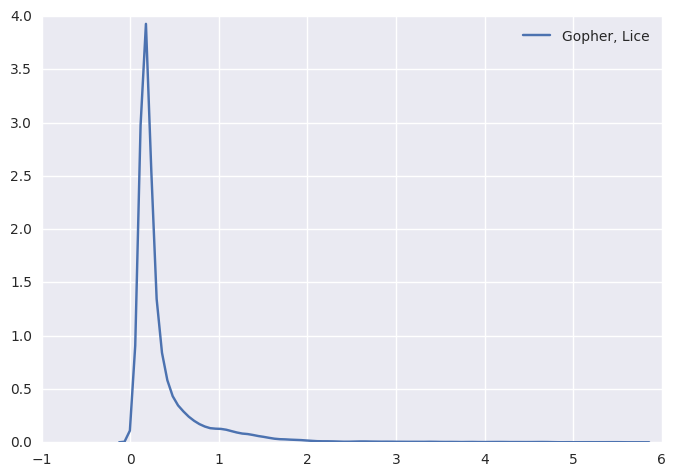

In [172]:
seaborn.kdeplot(AD['Gopher, Lice'])

In [176]:
AD['Gopher, Lice'][ AD['Gopher, Lice'] < 0.03 ]

177839    0.026857
154411    0.024439
154749    0.029276
88367     0.029442
Name: Gopher, Lice, dtype: float64

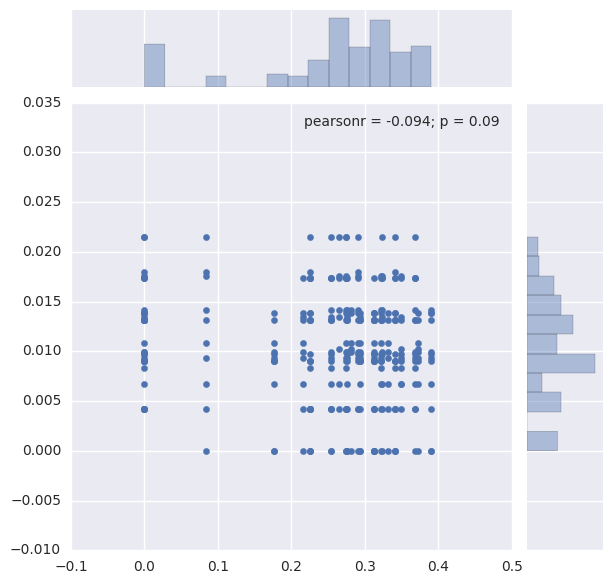

In [208]:
import seaborn

nodeid = 88367

SLT.subset_b( nodeid )
d = SLT.linked_distances()
seaborn.jointplot( d['TreeA'], d['TreeB'] )

In [189]:
import dendropy

microbe_tree = dendropy.Tree.get( path='dissertation_run_unique_2_pruned.tree', 
                                  schema='newick', preserve_underscores=True)

In [209]:
sfeal = dict( zip( SLT.TreeB.leafs.values(), SLT.TreeB.leafs.keys() ) )
clade_leafs = [ sfeal[x] for x in SLT.subset_b_leafs ]

microbe_tree.retain_taxa_with_labels( clade_leafs )

microbe_tree.write( path='dissertation_run_clade_' + str(nodeid) + '.tree', schema='newick' )

In [210]:
clinks = links[ clade_leafs ]
uclinks = clinks.applymap( bool ).unstack()
uclinks = uclinks[ uclinks ]
with open( str(cladeid) + '.links', 'w' ) as f :
    for pair in list(uclinks.index) :
        f.write( '\t'.join([ ''+i+'' for i in pair[::-1] ]) + '\n' )

In [215]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Rotating nodes to optimize matching...
Done.
png 
  2 


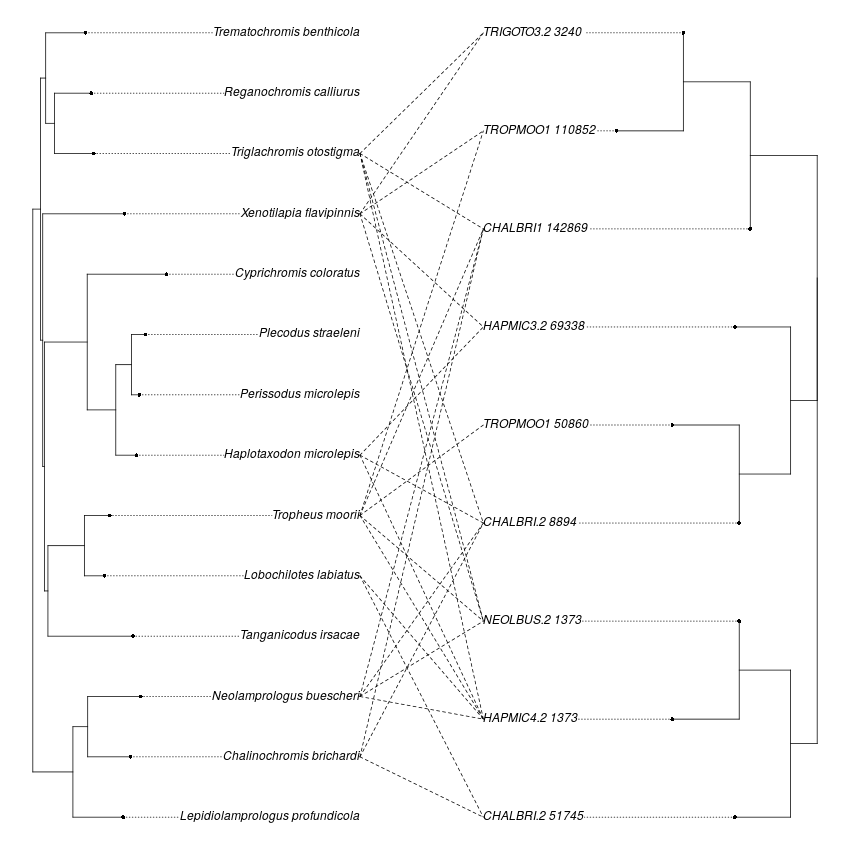

In [217]:
%%R -w 30 -h 30 -u cm

library('phytools')

tr1 <- read.tree( 'host_tree/mcgeetree/mcgee_trimmed.tree' )
tr2 <- read.newick( 'dissertation_run_clade_88367.tree' )
tr2 <- collapse.singles(tr2)
assoc = as.matrix(read.csv( '88367.links', sep='\t', header=FALSE ))
colnames(assoc)<-c('tips.tr1','tips.tr2')

obj <- cophylo( tr1, tr2, assoc=assoc )
plot(obj)

pdf('codiv_clade_88367.pdf', width = 10, height = 12 )
plot(setMap(obj,invert=TRUE))
dev.off()

[  8.88086367e-01   8.42535009e-02   1.63115829e-02   3.69403239e-03
   3.06549500e-03   1.52581211e-03   1.00979310e-03   6.87738717e-04
   4.59233167e-04   2.12187245e-04]


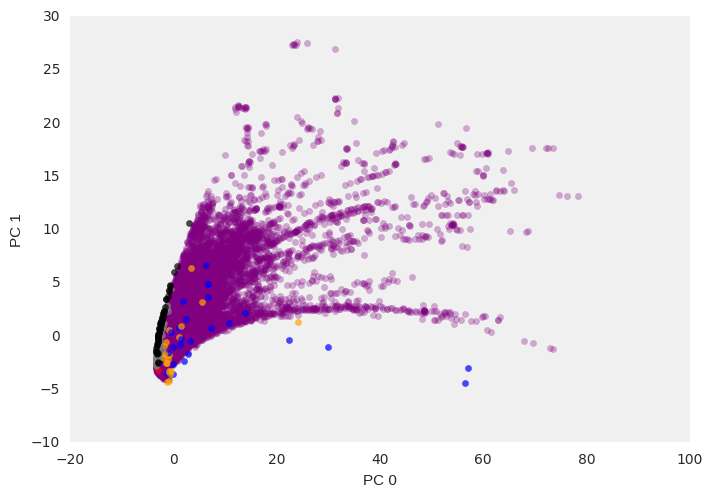

In [371]:
from sklearn.decomposition import PCA

Distances = pd.DataFrame(distances, index=Studies.index, columns=Studies.index)

X_data = Studies[['eigengap','kurtosis','skew','r','p']].join(Distances)
Y_data = spectral_stats.join( hommola[['r','p']] ).fillna(-1).join(AD)

typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'orange',
              'pollination' : 'blue' }

pca = PCA( n_components=10, whiten=False )
p = pca.fit( X_data )
X = p.transform( X_data )
Y = p.transform( Y_data )
print p.explained_variance_ratio_

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    ax = scatter( Y[:,0], Y[:,1], color='purple', alpha=0.3, label='fishpoo' )
    
    for st,x,y in zip( Studies['type'], X[:,0], X[:,1] ) :
        ax = scatter( [x], [y], color=typecolor[st], alpha=0.7, label=st )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'PC 0' )
    ylabel( 'PC 1' )
#legend()



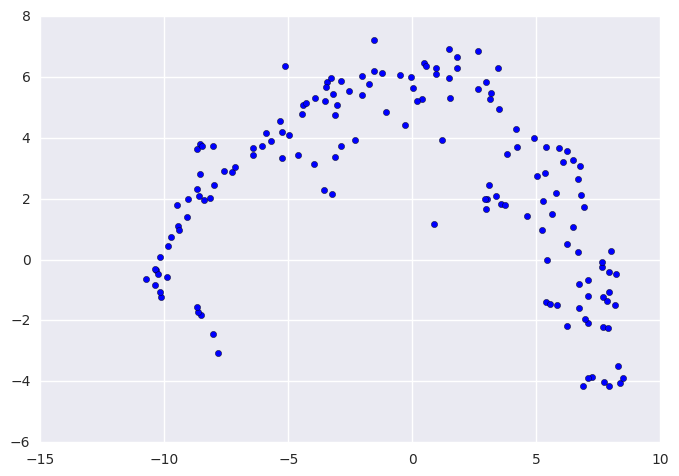

In [377]:
from sklearn.manifold import TSNE

#plot( AD['Gopher, Lice'], AD['Sedge, Smut'], 'ro', alpha=0.3 )

X_tsne = TSNE(learning_rate=100).fit_transform(X_data.T)
#Y_tsne = TSNE

scatter( X_tsne[:,0], X_tsne[:,1] )

In [444]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

#classifier = KNeighborsClassifier(3)
#classifier = SVC(kernel="linear", C=0.025)
#classifier = SVC(gamma=2, C=1)
#classifier = GaussianProcessClassifier(1.0 * RBF(1.0), warm_start=True)
#classifier = DecisionTreeClassifier(max_depth=5)
#classifier = RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
#classifier = AdaBoostClassifier()
#classifier = GaussianNB()
classifier = QuadraticDiscriminantAnalysis()

classifier.fit( X_data, Studies['type'] )

predictions = classifier.predict( Y_data )

/home/russell/opt/local/lib/python2.7/site-packages/sklearn/discriminant_analysis.py:695: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [445]:
classifier

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

In [446]:
predictions[:10]

array([u'perfect', u'parasitism', u'null', u'perfect', u'null', u'null',
       u'perfect', u'perfect', u'perfect', u'perfect'], dtype=object)

In [447]:
Predictions = pd.DataFrame(predictions, columns=['type'], index=Y_data.index)
Projecton = pd.DataFrame(Y, columns=[ 'PC%d' % i for i in range(10) ], index=Y_data.index)
PP = Predictions.join( Projecton )
PP.head()

,type,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
3,perfect,-2.904859,-2.487717,2.520806,-0.523801,-0.052573,0.616625,0.176244,0.406181,-0.028859,0.223214
5,parasitism,-2.838921,-2.558214,2.461758,-0.339474,-0.217042,0.708807,0.268350,0.473188,-0.091504,0.227587
7,null,1.661980,1.288054,-0.223203,-1.073421,-1.418730,0.072392,-0.275544,-0.359984,0.050685,0.083610
11,perfect,-2.704242,-2.267666,2.283152,-0.238302,-0.249169,0.694309,0.077693,0.187720,0.073592,0.384063
15,null,-1.302158,-2.289400,-0.175290,0.169538,-0.402643,-0.154778,-0.234352,-0.248208,0.043906,0.393287


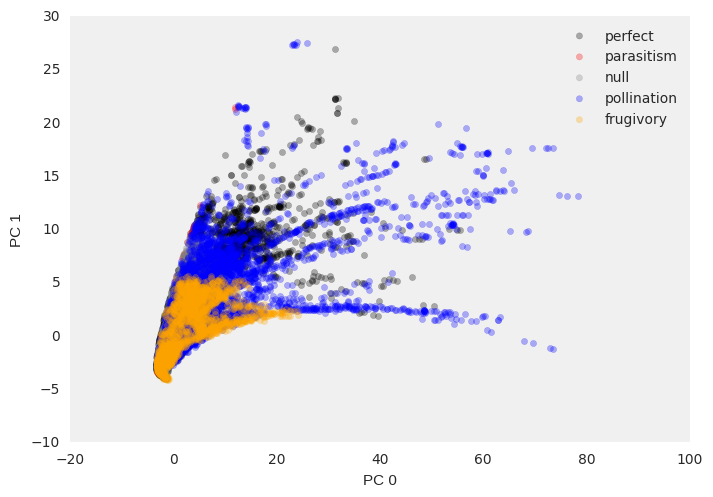

In [448]:
typecolor = { 'null'        : 'gray', 
              'perfect'     : 'black',
              'parasitism'  : 'red',
              'frugivory'   : 'orange',
              'pollination' : 'blue' }

with seaborn.axes_style("white") :

    subplot(axisbg='#F0F0F0')

    #ax = scatter( Y[:,0], Y[:,1], color='purple', alpha=0.3, label='fishpoo' )
    
    for st in typecolor.keys() :
        pp = PP[ PP['type'] == st ] 
        ax = scatter( pp['PC0'], pp['PC1'], color=typecolor[st], alpha=0.3, label=st )
    
    for side in ax.axes.spines.keys() :
        ax.axes.spines[side].set_visible(False)
    xlabel( 'PC 0' )
    ylabel( 'PC 1' )
    legend()